# HRS Spectrometer Neural Network Model

In [19]:
import  pandas as pd
import numpy as np
import sklearn
import math
import matplotlib
%matplotlib inline
import urllib
import os
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

## Prepare the data
| dataset | Coord | Intro                                                                                    | baseDir                                                                       |
| ------- | ----- | ---------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------- |
| 1       | focal | \- focal plane coord<br>\- only x,y,theta,phi<br>\- used for Deep Neural Network | [http://216.197.71.44/Data/spectro_nn/focalPlane/EqEvt731/](http://216.197.71.44/Data/spectro_nn/focalPlane/EqEvt731/order0/) |
| 2       | det plane | \- detector plane coord<br>\- used for Deep Neural Network<br>\- **equal** event number | [http://216.197.71.44/Data/spectro_nn/DetPlane/EqEvt731/](http://localhost/Data/spectro_nn/DetPlane/EqEvt731/) |
| 3       | det plane | \- detector plane coord<br>\- used for Deep Neural Network<br>\- **Unequal** event number | [http://216.197.71.44/Data/spectro_nn/DetPlane/UnEqEvt731/](http://localhost/Data/spectro_nn/DetPlane/UnEqEvt731/) |

- **Two type of dataset**
Only x,y,theta,phi : PRex_DataSet_xxx.csv
All the combinations: PRex_DataSet_Ful_xxx.csv
### 1). Load the files

In [20]:
dataSouceBaseDir = "http://localhost/Data/spectro_nn/DetPlane/EqEvt731/order5/"


files = ["{}/PRex_DataSet_2239.csv".format(dataSouceBaseDir),
         "{}/PRex_DataSet_2240.csv".format(dataSouceBaseDir),
         "{}/PRex_DataSet_2241.csv".format(dataSouceBaseDir),
         "{}/PRex_DataSet_2244.csv".format(dataSouceBaseDir),
         "{}/PRex_DataSet_2245.csv".format(dataSouceBaseDir),
         "{}/PRex_DataSet_2256.csv".format(dataSouceBaseDir),
         "{}/PRex_DataSet_2257.csv".format(dataSouceBaseDir)
         ]

li = []

for filename in files:
    print("Loading the file {}...".format(filename))
    df = pd.read_csv(filename)
    li.append(df)
data = pd.concat(li)
data.sample(frac=1) # sample the data with fraction 1. rearrange the data in random order
data.head()

Loading the file http://localhost/Data/spectro_nn/DetPlane/EqEvt731/order5//PRex_DataSet_2239.csv...
Loading the file http://localhost/Data/spectro_nn/DetPlane/EqEvt731/order5//PRex_DataSet_2240.csv...
Loading the file http://localhost/Data/spectro_nn/DetPlane/EqEvt731/order5//PRex_DataSet_2241.csv...
Loading the file http://localhost/Data/spectro_nn/DetPlane/EqEvt731/order5//PRex_DataSet_2244.csv...
Loading the file http://localhost/Data/spectro_nn/DetPlane/EqEvt731/order5//PRex_DataSet_2245.csv...
Loading the file http://localhost/Data/spectro_nn/DetPlane/EqEvt731/order5//PRex_DataSet_2256.csv...
Loading the file http://localhost/Data/spectro_nn/DetPlane/EqEvt731/order5//PRex_DataSet_2257.csv...


evtID  runID  CutID  SieveRowID  SieveColID      bpmX      bpmY   focal_x  \
0      0   2239    136           3           5  0.003794 -0.000501 -0.020509   
1      1   2239    130           4           4  0.003794 -0.000501 -0.038335   
2      2   2239    179           4          11  0.003794 -0.000501 -0.019525   
3      3   2239    142           2           6  0.003794 -0.000501 -0.015241   
4      4   2239    127           1           4  0.003794 -0.000501 -0.003100   

    focal_y  focal_th  focal_ph  targCalTh  targCalPh  
0 -0.000858  0.995474 -0.013557  -0.000817  -0.010117  
1 -0.003343  0.976738 -0.024061   0.019571  -0.012569  
2 -0.026806  0.981862  0.009713   0.012775   0.014835  
3 -0.008897  1.006900 -0.009250  -0.014409  -0.003863  
4  0.000314  1.011640 -0.016968  -0.021206  -0.012569

### 2). Check the Theoretical Value of $\theta$ and $\phi$ on targe

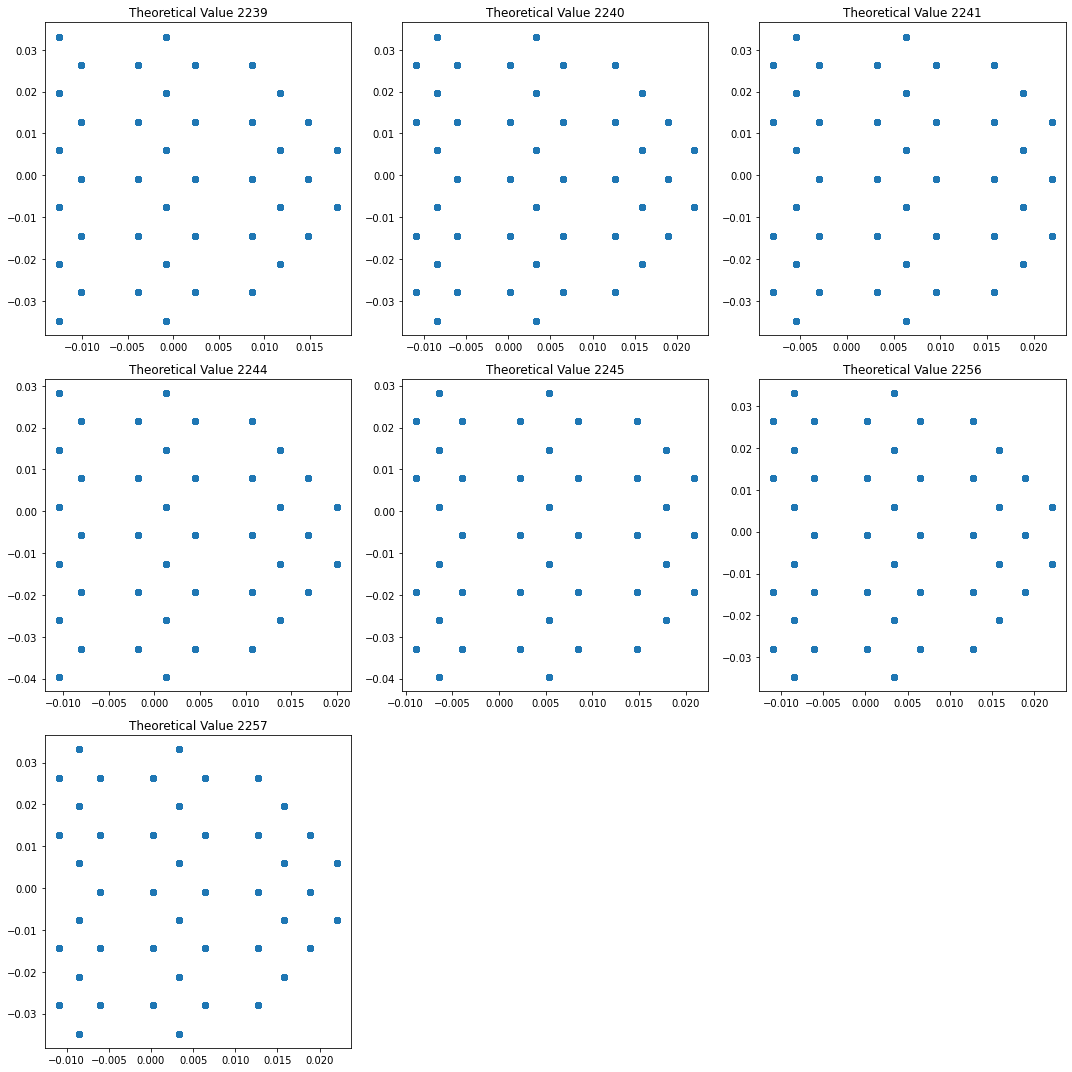

In [21]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=[15,15])
gs = gridspec.GridSpec(nrows=3, ncols=3, height_ratios=[1, 1, 1])

ax0 = fig.add_subplot(gs[0, 0])
ax0.scatter(data[data.runID.eq(2239)]["targCalPh"],data[data.runID.eq(2239)]["targCalTh"])
ax0.set_title('Theoretical Value 2239')

ax1 = fig.add_subplot(gs[0, 1])
ax1.scatter(data[data.runID.eq(2240)]["targCalPh"],data[data.runID.eq(2240)]["targCalTh"])
ax1.set_title('Theoretical Value 2240')

ax2 = fig.add_subplot(gs[0, 2])
ax2.scatter(data[data.runID.eq(2241)]["targCalPh"],data[data.runID.eq(2241)]["targCalTh"])
ax2.set_title('Theoretical Value 2241')

ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(data[data.runID.eq(2244)]["targCalPh"],data[data.runID.eq(2244)]["targCalTh"])
ax3.set_title('Theoretical Value 2244')

ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(data[data.runID.eq(2245)]["targCalPh"],data[data.runID.eq(2245)]["targCalTh"])
ax4.set_title('Theoretical Value 2245')

ax5 = fig.add_subplot(gs[1, 2])
ax5.scatter(data[data.runID.eq(2256)]["targCalPh"],data[data.runID.eq(2256)]["targCalTh"])
ax5.set_title('Theoretical Value 2256')

ax6 = fig.add_subplot(gs[2, 0])
ax6.scatter(data[data.runID.eq(2257)]["targCalPh"],data[data.runID.eq(2257)]["targCalTh"])
ax6.set_title('Theoretical Value 2257')

plt.tight_layout()
plt.show()

### 3). Pre-process the data

In [22]:
from sklearn.model_selection import train_test_split
from torch.utils.data import  Dataset, TensorDataset, DataLoader
import torch


train_X, test_X, train_y, test_y = train_test_split(
    data.drop(labels=['evtID','runID','SieveRowID','SieveColID','CutID','bpmX','bpmY','targCalTh','targCalPh'], axis=1),
    data[['targCalTh','targCalPh']],
    test_size=0.2,
    random_state=0)


train_X_tensor = torch.tensor(train_X.to_numpy()).float()
train_yTh_tensor = torch.tensor(train_y['targCalTh'].to_numpy()).float()
train_yPh_tensor = torch.tensor(train_y['targCalPh'].to_numpy()).float()

test_X_tensor  = torch.tensor(test_X.to_numpy()).float()
test_yTh_tensor  = torch.tensor(test_y['targCalTh'].to_numpy()).float()
test_yPh_tensor  = torch.tensor(test_y['targCalPh'].to_numpy()).float()

n_feature = train_X.shape[1]


train_X.head()



# train_theta_loader = DataLoader(dataset=TensorDataset(train_X_tensor,train_yTh_tensor),batch_size=batchSize)
# train_phi_loader   = DataLoader(dataset=TensorDataset(train_X_tensor,train_yPh_tensor),batch_size=batchSize)
#
# test_theta_loader = DataLoader(dataset=TensorDataset(test_X_tensor,test_yTh_tensor),batch_size=batchSize)
# test_phi_loader   = DataLoader(dataset=TensorDataset(test_X_tensor,test_yPh_tensor),batch_size=batchSize)

focal_x   focal_y  focal_th  focal_ph
22731 -0.200412 -0.030507  0.935733  0.012001
12002 -0.024033 -0.019042  1.018250 -0.008982
8741  -0.300968 -0.023342  0.926854 -0.005399
30567 -0.216262 -0.029985  0.964847  0.001228
32401 -0.212620 -0.031937  0.952657  0.012286

## Build the model and Get the GPUs

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class OptNet_Theta(nn.Module):
    def __init__(self,l1=120):
        super(OptNet_Theta,self).__init__()
        self.fc1 = nn.Linear(n_feature, l1)  # 6*6 from image dimension
        self.output = nn.Linear(l1, 1)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = self.output(x)
        return x

class OptNet_Phi(nn.Module):
    def __init__(self,l1=120,l2=120,l3=120,l4=120,l5=120):
        super(OptNet_Phi,self).__init__()
        self.fc1 = nn.Linear(n_feature, l1)  # 6*6 from image dimension
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, l3)
        self.fc4 = nn.Linear(l3, l4)
        self.fc5 = nn.Linear(l4, l5)
        # self.fc6 = nn.Linear(l5, l6)
        # self.fc7 = nn.Linear(l6, l7)

        self.output = nn.Linear(l5, 1)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        # x = F.sigmoid(self.fc6(x))
        # x = F.sigmoid(self.fc7(x))
        x = self.output(x)
        return x

## Train the model With All GPUs
### 1. Train the $\phi_{targ}$ dimension

In [24]:
def trainner_phi(config, checkpoint_dir=None, data_dir=None):
    net = OptNet_Phi(config["l1"],
                     config["l2"],
                     config["l3"],
                     config["l4"],
                     config["l5"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainloader = DataLoader(
        dataset=TensorDataset(train_X_tensor,train_yPh_tensor),
        shuffle=True,
        batch_size=int(config["batch_size"]))

    valloader = DataLoader(
        dataset=TensorDataset(test_X_tensor,test_yPh_tensor),
        shuffle=True,
        batch_size=int(config["batch_size"]))

    # TODO change the to setting file epoch ??
    for epoch in range(20):
        running_loss = 0.0
        epoch_steps = 0

        for  i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            #forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d, %7f] loss: %.9f" % (epoch + 1, i + 1,
                                                     optimizer.param_groups[0]['lr'],
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                # _, predicted = torch.max(outputs.data, 1)
                # total += labels.size(0)
                # correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps))
    print("Finish Training")

### 1. Train the $\theta_{targ}$ dimension

In [25]:
def trainner_theta(config, checkpoint_dir=None, data_dir=None):
    net = OptNet_Theta(config["l1"])#,config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainloader = DataLoader(
        dataset=TensorDataset(train_X_tensor,train_yTh_tensor),
        shuffle=True,
        batch_size=int(config["batch_size"]))

    valloader = DataLoader(
        dataset=TensorDataset(test_X_tensor,test_yTh_tensor),
        shuffle=True,
        batch_size=int(config["batch_size"]))

    # TODO change the to setting file epoch ??
    for epoch in range(10):
        running_loss = 0.0
        epoch_steps = 0

        for  i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            #forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d, %6f] loss: %.9f" % (epoch + 1, i + 1,
                                                     optimizer.param_groups[0]['lr'],
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                # _, predicted = torch.max(outputs.data, 1)
                # total += labels.size(0)
                # correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps))
    print("Finish Training")

### 3. trainner runner

In [26]:
from functools import partial

def trainPhi_run(num_samples=10, max_num_epochs=20, gpus_per_trial=1):
    data_dir = os.path.abspath("./data")
    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l3": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l4": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l5": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        # "l6": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        # "l7": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "lr": tune.loguniform(1e-6, 1),
        "batch_size": tune.choice([2, 4, 8, 16,32,64])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)

    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "training_iteration"])

    result = tune.run(
        partial(trainner_phi, data_dir=data_dir),
        name="phi_scan_6",
        resources_per_trial={"cpu": 1, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    # print("Best trial final validation accuracy: {}".format(
    #     best_trial.last_result["accuracy"]))

    best_trained_model = OptNet_Phi(best_trial.config["l1"], best_trial.config["l2"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)
    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

## Train Main Runner

In [27]:
trainPhi_run(num_samples=500, max_num_epochs=20, gpus_per_trial=0)

2021-03-12 15:39:18,410	WARNING experiment.py:291 -- No name detected on trainable. Using DEFAULT.
2021-03-12 15:39:18,410	INFO registry.py:64 -- Detected unknown callable for trainable. Converting to class.
2021-03-12 20:02:00,640	INFO tune.py:450 -- Total run time: 15762.23 seconds (15762.12 seconds for the tuning loop).


== Status ==
Memory usage on this node: 11.2/31.3 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1/8 CPUs, 0/1 GPUs, 0.0/15.97 GiB heap, 0.0/5.52 GiB objects (0/1.0 accelerator_type:GTX)
Result logdir: /home/newdriver/ray_results/phi_scan_6
Number of trials: 1/500 (1 RUNNING)
+---------------------+----------+-------+--------------+------+------+------+------+------+------------+
| Trial name          | status   | loc   |   batch_size |   l1 |   l2 |   l3 |   l4 |   l5 |         lr |
|---------------------+----------+-------+--------------+------+------+------+------+------+------------|
| DEFAULT_0475d_00000 | RUNNING  |       |            8 |   32 |  256 |   16 |   64 |   32 | 0.00151854 |
+---------------------+----------+-------+--------------+------+------+------+------+------+------------+


Result for DEFAULT_0475d_00005:
  date: 2021-03-12_15-39-26
  done: false


RuntimeError: Error(s) in loading state_dict for OptNet_Phi:
	size mismatch for fc3.weight: copying a param with shape torch.Size([16, 16]) from checkpoint, the shape in current model is torch.Size([120, 16]).
	size mismatch for fc3.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([120]).
	size mismatch for fc4.weight: copying a param with shape torch.Size([32, 16]) from checkpoint, the shape in current model is torch.Size([120, 120]).
	size mismatch for fc4.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([120]).
	size mismatch for fc5.weight: copying a param with shape torch.Size([256, 32]) from checkpoint, the shape in current model is torch.Size([120, 120]).
	size mismatch for fc5.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([120]).
	size mismatch for output.weight: copying a param with shape torch.Size([1, 256]) from checkpoint, the shape in current model is torch.Size([1, 120]).

## Result Validation